In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import clip
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Dataset**

In [2]:
from VQA_Dataset import VQA_Dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

dataset = VQA_Dataset()
dataset.load_all(preprocess, length=4000, device=device)

#Testing dataset
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for element in tqdm(dataloader, desc="Testing"):
    ids_batch = element['image_id']
    for i, id in enumerate(ids_batch):
        if id == 26216:
            print(element["question"][i])#, "question: ", i['question_tokens'], "answer: ", i['answer_tokens'])

'from VQA_Dataset import VQA_Dataset\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\nmodel, preprocess = clip.load("ViT-B/32", device=device)\n\ndataset = VQA_Dataset()\ndataset.load_all(preprocess, length=3000, device=device)\n\n#Testing dataset\ndataloader = DataLoader(dataset, batch_size=2, shuffle=True)\n\nfor element in tqdm(dataloader, desc="Testing"):\n    ids_batch = element[\'image_id\']\n    for i, id in enumerate(ids_batch):\n        if id == 26216:\n            print(element["question"][i])#, "question: ", i[\'question_tokens\'], "answer: ", i[\'answer_tokens\'])'

**Test-train split**

Train size:  3200
Test size:  400


TypeError: list indices must be integers or slices, not str

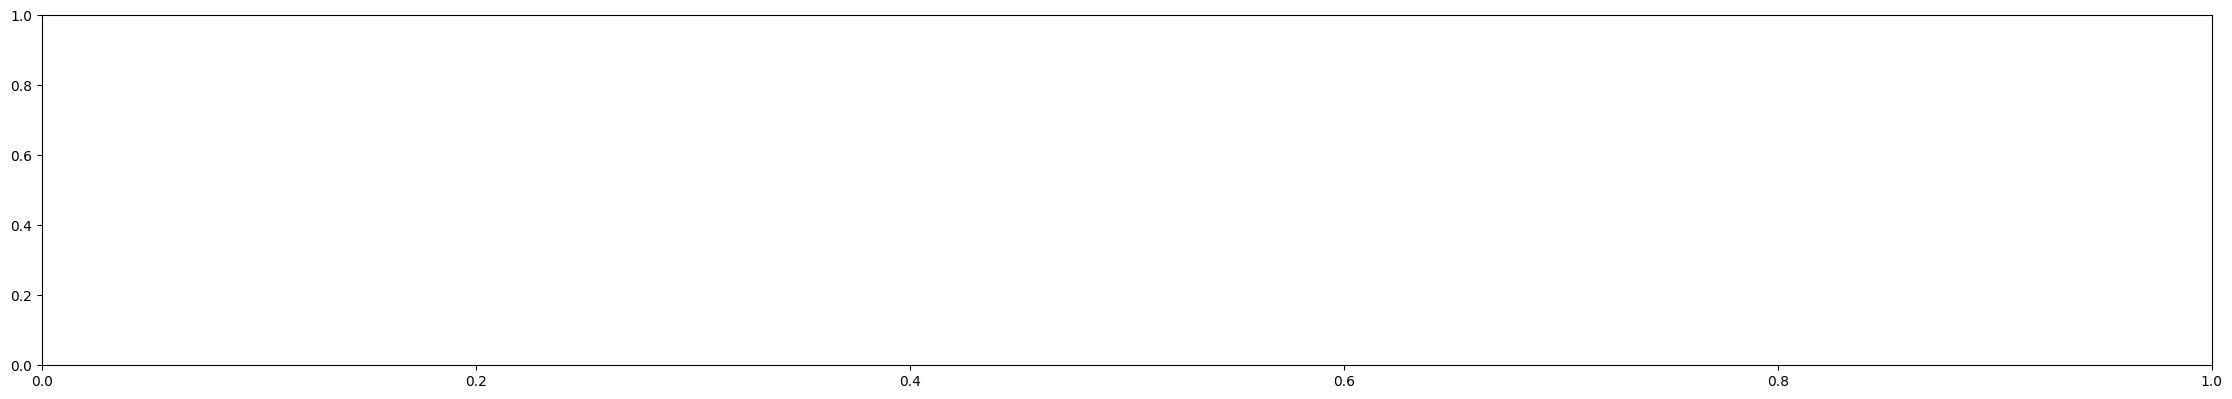

In [5]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset)*0.8)
val_size = int(len(dataset)*0.1)
test_size = int(len(dataset))-train_size-val_size
generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
print("Train size: ", train_size)
print("Test size: ", test_size)

batch_size=2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#Checking data
fig=plt.figure(0, (28, 10))
for element in train_dataloader:
    for i in range(batch_size):
        ax = fig.add_subplot(2,int(batch_size/2),i+1)
        
        ax.imshow(np.transpose(element["image"][i].squeeze(0).cpu(), (1, 2, 0))) #Converting to matplotlib format
        ax.set_title("Question: "+str(element["question"][i])+"\nAnswer: "+str(element["correct_answer_text"][i])+" "+str(element["image_id"][i]), fontsize=9)
    break

**Model**

In [4]:
from models import VQA_Model4

#CLIP
clip_model, preprocess = clip.load('ViT-B/32', device)
vqa_model = VQA_Model4(clip_model, device)

# Freezing clip model: Without this, gradients scales were different (clip and mlp gradients), generated exploding gradient 
for param in vqa_model.model.parameters():
    param.requires_grad = False

In [5]:
import os
from PIL import Image
from torchvision import transforms

img = Image.open(os.path.join("Images", "abstract_v002_val2015_000000029903.png"))
image_input = preprocess(img).unsqueeze(0).to(device)
print("Image preprocessed: ",image_input.shape)

image_features = clip_model.encode_image(image_input)
print("Image encoded size: ", image_features.shape)

text = clip.tokenize(["a diagram of the dof" , "a dog", "a cat"]).to(device)
print("Text tokenized size: ",text.shape)

text_features = clip_model.encode_text(text)
print("Text encoded size: ",text_features.shape)

Image preprocessed:  torch.Size([1, 3, 224, 224])
Image encoded size:  torch.Size([1, 512])
Text tokenized size:  torch.Size([3, 77])
Text encoded size:  torch.Size([3, 512])


**Training & Optim**

In [6]:
def train(dataloader, vqa_model, loss_function, optimizer, clip_value):
    size = len(dataloader.dataset)
    vqa_model.train()

    for batch, (data) in enumerate(dataloader):    
        images = data["image"].squeeze(1)
        question_tokens = data["question_tokens"].squeeze(1)
        answer_tokens = data["answer_tokens"].squeeze(1)
        similarity_pred = vqa_model(images, question_tokens, answer_tokens)

        similarity_label_arg = data["correct_answer_idx"].to(device)
        
        loss = loss_function(similarity_pred, similarity_label_arg)

        # #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(vqa_model.parameters(), max_norm=clip_value, error_if_nonfinite=True)

        optimizer.step()

        if batch % 50 ==0:
            loss, current = loss.item(), batch*len(images)
            print("loss: ", loss, current, size)

In [7]:
def eval(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader:    
            images = data["image"].squeeze(1)
            question_tokens = data["question_tokens"].squeeze(1)
            answer_tokens = data["answer_tokens"].squeeze(1)
            similarity_pred = model(images, question_tokens, answer_tokens)

            similarity_label_arg = torch.tensor(data["correct_answer_idx"]).to(device)
            
            val_loss += loss_function(similarity_pred, similarity_label_arg)
            correct += (similarity_pred.argmax(1) == similarity_label_arg).type(torch.float).sum().item()
            
    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return 100*correct

In [8]:
#Hyperparameters and optim
from torch import nn

loss_fn = nn.CrossEntropyLoss()
clip_value = 1.0
learning_rate = 1e-4
optimizer = torch.optim.Adam(vqa_model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateu(optimizer, patience=5, verbose=True) #Scheduler

In [9]:
#Early stopping parameters
import os

n_epochs = 50
early_stop_threshhold = 5
best_accuracy = -1
best_epoch = -1

def checkpoint(model, filename):
    folder_path = os.path.join("runs", "checkpoint_SolvingCropping")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    torch.save(model.state_dict(), os.path.join(folder_path, filename))
    
def resume(model, filename):
    model.load_state_dict(torch.load(os.path.join("runs", "checkpoint_SolvingCropping", filename)))

In [10]:
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, vqa_model, loss_fn, optimizer, clip_value)
    acc = eval(val_dataloader, vqa_model, loss_fn)
    if acc>best_accuracy:
        best_accuracy = acc
        best_epoch = epoch
        checkpoint(vqa_model, "best_model.pth")
    elif (epoch-best_epoch) > early_stop_threshhold:
        print("--Early stopped training--")
        break

Epoch 1
-------------------------------
loss:  2.749495267868042 0 2400
loss:  2.4484424591064453 100 2400
loss:  1.5176622867584229 200 2400
loss:  3.8358585834503174 300 2400
loss:  1.4069647789001465 400 2400
loss:  1.5639595985412598 500 2400
loss:  0.8599292635917664 600 2400
loss:  1.6704210042953491 700 2400
loss:  1.8656642436981201 800 2400
loss:  1.3267436027526855 900 2400
loss:  1.8402092456817627 1000 2400
loss:  1.0737415552139282 1100 2400
loss:  0.8069823980331421 1200 2400
loss:  1.6569902896881104 1300 2400
loss:  2.107916831970215 1400 2400
loss:  2.088829278945923 1500 2400
loss:  1.3075658082962036 1600 2400
loss:  1.3777270317077637 1700 2400
loss:  1.7279810905456543 1800 2400
loss:  2.141223669052124 1900 2400
loss:  1.842322826385498 2000 2400
loss:  4.026528835296631 2100 2400
loss:  3.2461729049682617 2200 2400
loss:  0.9547348618507385 2300 2400


C:\Users\Zetans\AppData\Local\Temp\ipykernel_14016\1468784600.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  similarity_label_arg = torch.tensor(data["correct_answer_idx"]).to(device)


Test Error: 
 Accuracy: 42.3%, Avg loss: 1.748039 

Epoch 2
-------------------------------
loss:  0.9593484401702881 0 2400
loss:  0.6302608847618103 100 2400
loss:  0.9160096645355225 200 2400
loss:  0.8039377927780151 300 2400
loss:  3.3930606842041016 400 2400
loss:  1.9742428064346313 500 2400
loss:  3.1940197944641113 600 2400
loss:  1.29179847240448 700 2400
loss:  1.7889981269836426 800 2400
loss:  0.609059751033783 900 2400
loss:  1.081984519958496 1000 2400
loss:  1.952327013015747 1100 2400
loss:  1.9396013021469116 1200 2400
loss:  0.846930742263794 1300 2400
loss:  0.582335352897644 1400 2400
loss:  1.3503772020339966 1500 2400
loss:  1.938119649887085 1600 2400
loss:  2.3272695541381836 1700 2400
loss:  0.7953585386276245 1800 2400
loss:  1.6516739130020142 1900 2400
loss:  2.0259063243865967 2000 2400
loss:  1.8585820198059082 2100 2400
loss:  0.9327870607376099 2200 2400
loss:  3.569924831390381 2300 2400
Test Error: 
 Accuracy: 43.0%, Avg loss: 1.617954 

Epoch 3
-----